# Introduction to Synthetic Population Generation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population, trace_to_pam

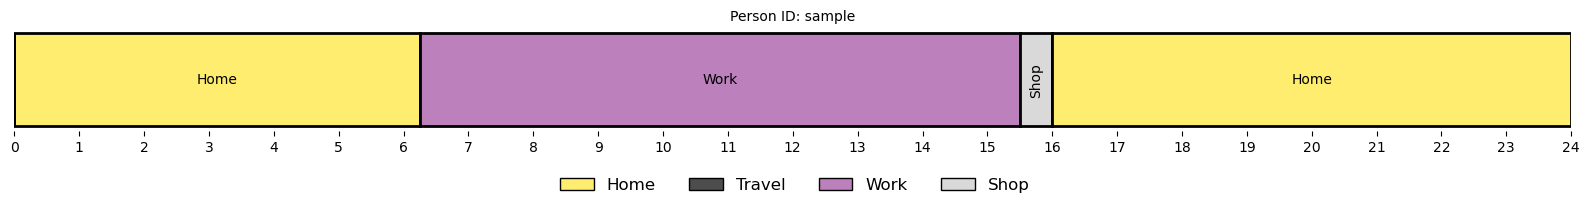

In [2]:
generator = ActivityGen()
generator.build()

trace = generator.run()
plan = trace_to_pam(trace, generator.map)
plan.plot()

In [3]:
population = generate_population(gen=generator, size=10000)
population.act = population.act.map(generator.map)
population

,act,start,end,duration,pid
0,home,0,390,390,0
1,shop,390,450,60,0
2,work,450,915,465,0
3,leisure,915,990,75,0
4,home,990,1440,450,0
...,...,...,...,...,...
50340,home,0,375,375,9999
50341,shop,375,390,15,9999
50342,work,390,930,540,9999
50343,leisure,930,1005,75,9999


In [4]:
population.to_csv("example_population.csv")

In [5]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    # description.set_index(("attribute", "act"))
    return description


describe_cols(population, ["start", "end", "duration"]).round()

count   mean    std    min     max
attribute act                                            
start     education   4536.0  867.0  178.0  390.0  1185.0
          home       21453.0  554.0  522.0    0.0  1380.0
          leisure     6113.0  826.0  287.0  375.0  1305.0
          shop        8202.0  631.0  291.0  375.0  1335.0
          work       10041.0  419.0   51.0  375.0  1260.0
end       education   4536.0  983.0  166.0  405.0  1200.0
          home       21453.0  929.0  512.0  375.0  1440.0
          leisure     6113.0  889.0  301.0  390.0  1380.0
          shop        8202.0  667.0  287.0  390.0  1350.0
          work       10041.0  932.0   74.0  735.0  1275.0
duration  education   4536.0  115.0   51.0   15.0   285.0
          home       21453.0  375.0   75.0   15.0   600.0
          leisure     6113.0   62.0   27.0   15.0   210.0
          shop        8202.0   36.0   24.0   15.0   180.0
          work       10041.0  513.0   66.0   15.0   690.0

In [6]:
def time_distributions(population: pd.DataFrame, mapping: dict):
    starts = {k: [] for k in mapping.values()}
    ends = {k: [] for k in mapping.values()}
    durations = {k: [] for k in mapping.values()}
    for act, acts in population.groupby("act"):
        starts[act] = list(acts.start)
        ends[act] = list(acts.end)
        durations[act] = list(acts.duration)
    return starts, ends, durations

In [7]:
starts, ends, durations = time_distributions(population, generator.map)

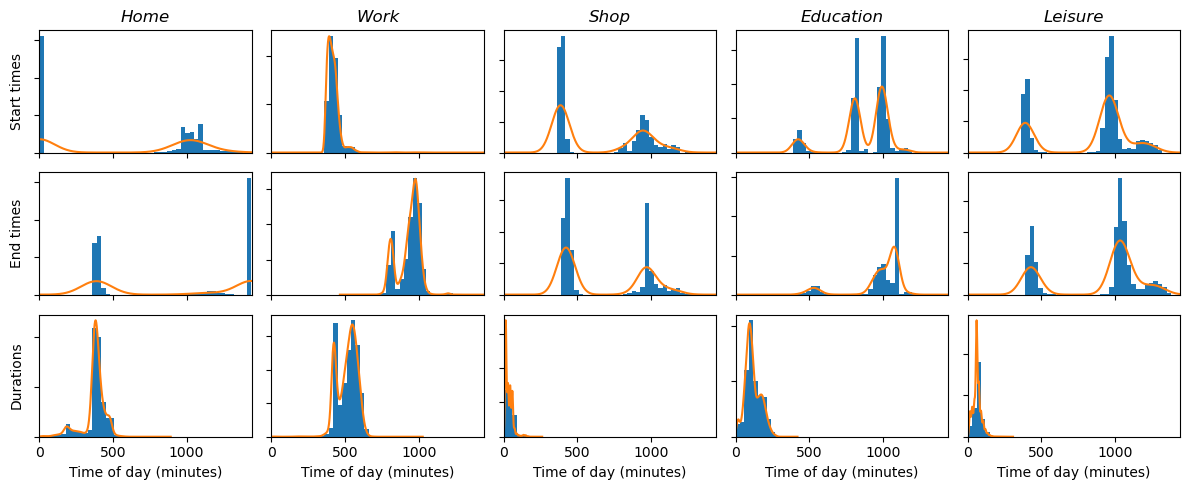

In [8]:
step = 30
mini = 0
maxi = 1441
ind = 1000
bw_method = 0.2

bins = list(range(mini, maxi, step))
fig, axs = plt.subplots(
    3,
    len(starts),
    figsize=(12, 5),
    sharex=True,
    sharey=False,
    tight_layout=True,
)
for i, act in enumerate(starts.keys()):
    axs[0][i].set_title(act.title(), fontstyle="italic")
    axs[0][i].hist(starts[act], bins=bins, density=True)
    pd.Series(starts[act]).plot.kde(ind=ind, bw_method=bw_method, ax=axs[0][i])
    axs[0][i].set_xlim(mini, maxi)
    axs[0][i].set_yticklabels([])
    axs[0][i].set(ylabel=None)
    axs[0][0].set(ylabel="Start times")

    axs[1][i].hist(ends[act], bins=bins, density=True)
    pd.Series(ends[act]).plot.kde(ind=ind, bw_method=bw_method, ax=axs[1][i])
    axs[1][i].set_xlim(mini, maxi)
    axs[1][i].set_yticklabels([])
    axs[1][i].set(ylabel=None)
    axs[1][0].set(ylabel="End times")

    axs[2][i].hist(durations[act], bins=bins, density=True)
    pd.Series(durations[act]).plot.kde(
        ind=ind, bw_method=bw_method, ax=axs[2][i]
    )
    axs[2][i].set_xlim(mini, maxi)
    axs[2][i].set_yticklabels([])
    axs[2][i].set(ylabel=None)
    axs[2][0].set(ylabel="Durations")
    axs[2][i].set(xlabel="Time of day (minutes)")

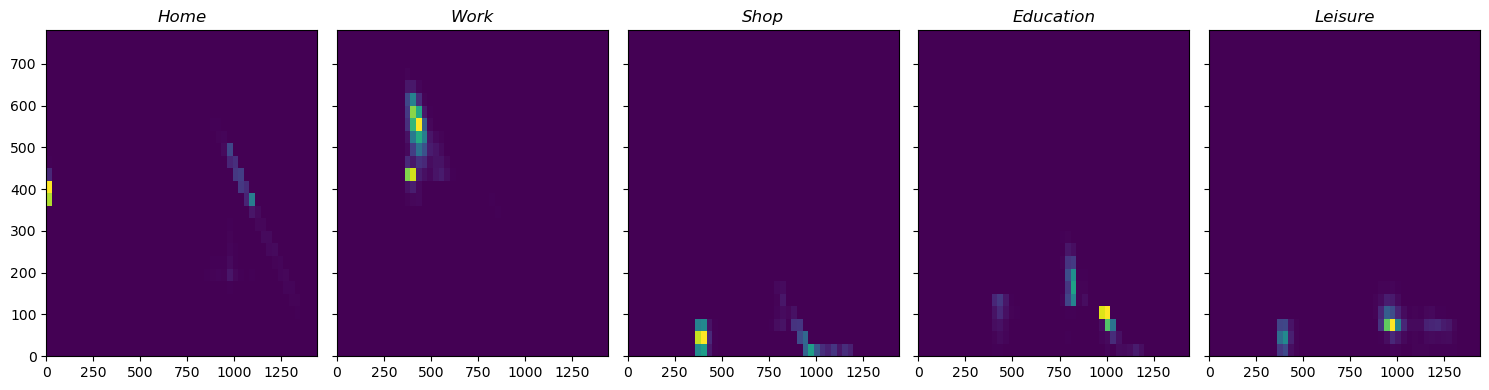

In [9]:
step = 30
mini = 0
maxi = 1441

bins = list(range(mini, maxi, step))
duration_bins = list(range(mini, 800, step))

fig, axs = plt.subplots(
    1, len(starts), figsize=(15, 4), sharex=True, sharey=True, tight_layout=True
)
for i, (act, act_starts) in enumerate(starts.items()):
    act_durations = durations[act]

    axs[i].set_title(act.title(), fontstyle="italic")
    # axs[i].set_xlim(0, 1440)
    # axs[i].set_ylim(0, 1440)
    axs[i].hist2d(act_starts, act_durations, bins=(bins, duration_bins))